In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def quantize(numbers, total_bits, fractional_bits, signed=True, enforce_symmetry=False):

    numbers = np.round(numbers * 2**fractional_bits)
    max_value = 2**total_bits
    if signed:
        max_value -= 1
    numbers[numbers > max_value] = max_value
    if signed:
        min_value = -(2 ** total_bits)
        if enforce_symmetry:
            min_value += 1
        numbers[numbers < min_value] = min_value
    numbers /= 2**fractional_bits
    return numbers

In [15]:
stddev = 5e-4
nfreqs = 512
input_unquantized = np.random.normal(scale=stddev, size=(nfreqs)) + 1j * np.random.normal(
    scale=stddev, size=(nfreqs)
)
input_quantized = quantize(
    np.real(input_unquantized), 18, 17, signed=True
) + 1j * quantize(np.imag(input_unquantized), 18, 17, signed=True)

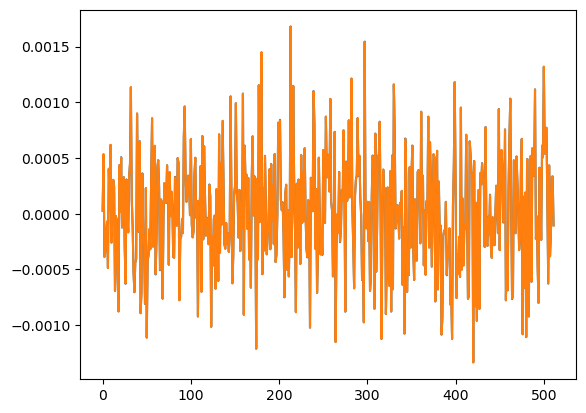

In [16]:
plt.plot(np.real(input_unquantized))
plt.plot(np.real(input_quantized))
plt.show()

In [17]:
coeffs_unquantized = np.linspace(250, 350, num=nfreqs)
coeffs_quantized = quantize(
    coeffs_unquantized, 16, 2, signed=False
)

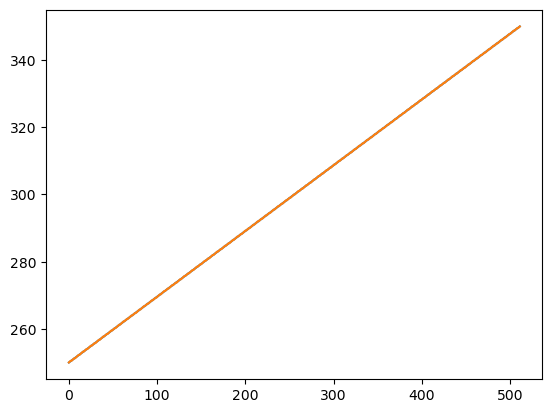

In [18]:
plt.plot(coeffs_unquantized)
plt.plot(coeffs_quantized)
plt.show()

In [19]:
equalized_voltage = input_quantized * coeffs_quantized
equalized_voltage_quantized = quantize(
    np.real(equalized_voltage), 4, 3, signed=True, enforce_symmetry=True
) + 1j * quantize(np.imag(equalized_voltage), 4, 3, signed=True, enforce_symmetry=True)

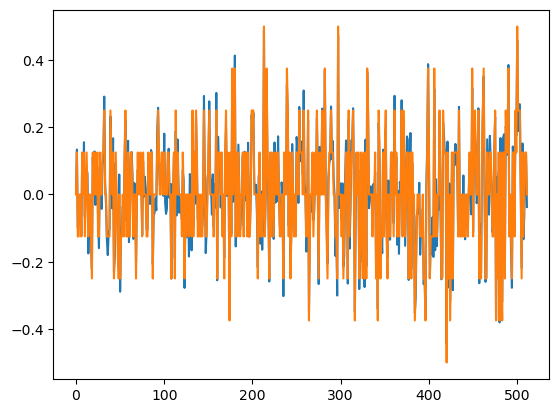

In [20]:
plt.plot(np.real(equalized_voltage))
plt.plot(np.real(equalized_voltage_quantized))
plt.show()

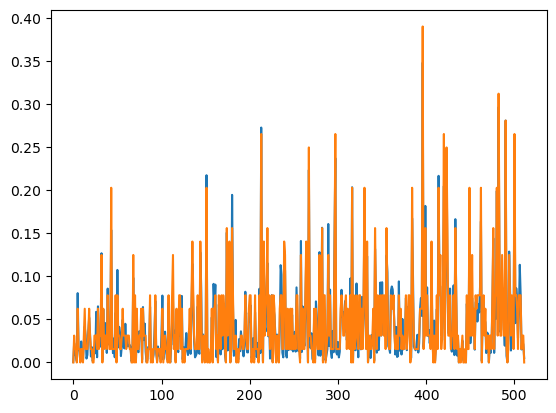

In [21]:
plt.plot(np.abs(equalized_voltage)**2)
plt.plot(np.abs(equalized_voltage_quantized)**2)
plt.show()

In [ ]:
# Now accumulate

def get_equalized_spectra(noise_stddev=1e-3, equalization_coeffs=np.linspace(250, 350, num=nfreqs)):
    input_unquantized = np.random.normal(
        scale=noise_stddev, size=(nfreqs)
    ) + 1j * np.random.normal(scale=stddev, size=(nfreqs))
    input_quantized = quantize(
        np.real(input_unquantized), 18, 17, signed=True
    ) + 1j * quantize(np.imag(input_unquantized), 18, 17, signed=True)
    coeffs_quantized = quantize(equalization_coeffs, 16, 2, signed=False)
    equalized_voltage = input_quantized * coeffs_quantized
    equalized_voltage_quantized = quantize(
        np.real(equalized_voltage), 4, 3, signed=True, enforce_symmetry=True
    ) + 1j * quantize(np.imag(equalized_voltage), 4, 3, signed=True, enforce_symmetry=True)
    return equalized_voltage_quantized

ntrials = 1024**2
accumulated_autocorr = np.zeros((nfreqs), dtype=float)
for ind in range(ntrials):
    new_spectrum = get_equalized_spectra()
    accumulated_autocorr += np.abs(new_spectrum) ** 2
# Normalize
accumulated_autocorr /= ntrials

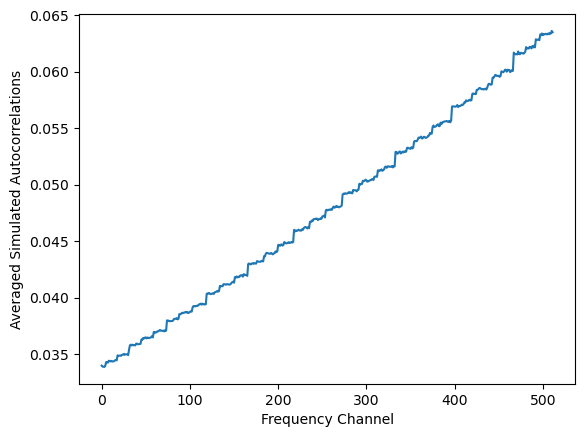

In [24]:
plt.plot(accumulated_autocorr)
plt.ylabel("Averaged Simulated Autocorrelations")
plt.xlabel("Frequency Channel")
plt.show()